# Importing packages

In [68]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import collections as c
import os
import re
import numpy as np
import scipy.spatial.distance as sp
import math
import matplotlib.pyplot as plt

ps = PorterStemmer() 
sno = SnowballStemmer("english")

[nltk_data] Downloading package punkt to /Users/anyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/anyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Get list of file names

In [2]:
filenames = []
for fn in os.listdir("enron1/ham"):
    if fn.endswith(".txt"):
        filenames.append(os.path.join("enron1/ham", fn.replace("\\", "/")))
        
ham_num = len(filenames)

for fn in os.listdir("enron1/spam"):
    if fn.endswith(".txt"):
        filenames.append(os.path.join("enron1/spam", fn.replace("\\", "/")))
    
spam_num = len(filenames) - ham_num

In [3]:
len(filenames)

5172

# Stem email text

In [18]:
#flag to set initial df
first = True
stems_list = []
#iterate through each file
for fn in filenames:  
    #read file
    with open(fn, 'r', encoding="ISO-8859-1") as file:
        
        #remove numbers
        data = re.sub('[0-9]', '', file.read().replace('\n', ' '))
        
        #data = file.read().replace('\n', ' ')
        
        #tokenize + word-stem
        nltk_tokens = word_tokenize(data)
        stems = ""
        for w in nltk_tokens:
            stems += ps.stem(w) + " "
        
        stems_list.append(stems)


# Vectorize counts and get dictionary

In [19]:
#count vectorize
vect = CountVectorizer(input="content")
temp = vect.fit_transform(stems_list)
word_bag = vect.get_feature_names()

In [52]:
df = pd.DataFrame(temp.toarray(), columns=word_bag)

In [53]:
df.drop([col for col, val in df.sum().iteritems() if val <= 50], axis=1, inplace=True)

In [54]:
df.shape

(5172, 1645)

In [55]:
#dropping stop words
drop_stop = True

if drop_stop:
    nonstop_attr = df.columns.copy()
    for word in stopwords.words('english'):
        if word in df.columns:
            nonstop_attr = nonstop_attr.drop(word)
else:
    nonstop_attr = df.columns

In [56]:
len(df.columns)-len(nonstop_attr)

100

# Divide data into ham, spam, test, and train

In [57]:
df_nonstop = df[nonstop_attr].copy()[nonstop_attr]

ham_data = df_nonstop[:ham_num]
spam_data = df_nonstop[ham_num:]
ham_data["SPAM_LABEL"] = 0
spam_data["SPAM_LABEL"] = 1

msk0 = np.random.rand(len(ham_data)) < 0.7
ham_train = ham_data[msk0]
ham_test = ham_data[~msk0]

msk1 = np.random.rand(len(spam_data)) < 0.7
spam_train = spam_data[msk1]
spam_test = spam_data[~msk1]

train_data = pd.concat([ham_train, spam_train])
test_data = pd.concat([ham_test, spam_test])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
test_data

# K Nearest Neighbors

Setting up parameters

In [64]:
def KNN(k, p, train_data):
    attr = train_data.columns.drop("SPAM_LABEL")
    train_data_knn = train_data.copy()
    test_data_knn = test_data.copy()
    test_data_knn["y"] = -1

    for i in range(len(test_data_knn.index)):
        distance = sp.cdist(train_data_knn[attr], test_data_knn[attr][i:i+1], 'minkowski', p)
        neighbors = np.apply_along_axis(np.argpartition, 0, distance, k)[:k] 
        test_data_knn.iloc[i]["y"] = train_data_knn.iloc[list(neighbors[:, 0]), :]["SPAM_LABEL"].mode()[0]

    return len(test_data_knn[test_data_knn["SPAM_LABEL"] == test_data_knn["y"]].index)/len(test_data_knn.index)

In [65]:
KNN(5, 2, train_data)

0.8579201934703748

In [66]:
# Plot performance against p
x = [1,2,3,4,5,200,1000]
x_ = ['1','2','3','4','5','200','1000']
y = []
for p in x:
    y.append(KNN(90, p, train_data))
    
plt.xlabel("Distance Metric p")
plt.ylabel("Accuracy")
plt.plot(x_, y, linewidth=2.0)
plt.title("KNN Performance Accuracy against p")

NameError: name 'plt' is not defined

Text(0.5, 1.0, 'KNN Performance Accuracy against p')

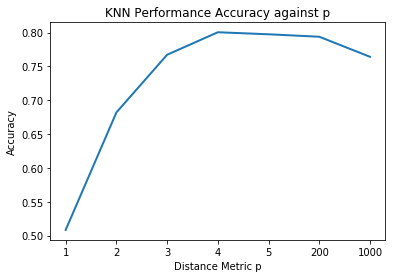

In [69]:
plt.xlabel("Distance Metric p")
plt.ylabel("Accuracy")
plt.plot(x_, y, linewidth=2.0)
plt.title("KNN Performance Accuracy against p")

In [ ]:
# Plot performance against k
x = [1,10,50,100,500,2000]
y = []
for k in x:
    y.append(KNN(k, 1, train_data))
    
plt.xlabel("Number of Neighbors k")
plt.ylabel("Accuracy")
plt.plot(x, y, linewidth=2.0)
plt.title("KNN Performance Accuracy against k")

# Naive Bayes

We use add-one Laplace smoothing and log the probabilities to avoid zero-frequency problem.

In [14]:
def bayes_prob(row, freq, attr, total):
    p = 0
    for i in range(len(attr)):
        #using add-one laplacian smoothing
        p += math.log((freq[i][row[i+1]]+1)/total)        
    return p

In [ ]:
def NB(train_data):
    #split data 
    train_data_b0 = train_data[train_data.SPAM_LABEL==0]
    train_data_b1 = train_data[train_data.SPAM_LABEL==1]

    #get counts and adjust for proportion
    counts = train_data.SPAM_LABEL.value_counts()
    train_data_b0 = train_data_b0/counts[0]
    train_data_b1 = train_data_b1/counts[1]
    counts = counts/counts.sum()

    #get test data
    test_data_bayes = test_data.copy()
    test_data_bayes["y"] = -1

    #classification
    for row in test_data.itertuples():
        p_0 = bayes_prob(row, train_data_b0, attr) * counts[0]
        p_1 = bayes_prob(row, train_data_b1, attr) * counts[1]

        #give label
        if p_0 > p_1:
            test_data_bayes["y"].loc[row[0]] = 0
        else:
            test_data_bayes["y"].loc[row[0]] = 1
    
    return len(test_data_bayes[test_data_bayes.SPAM_LABEL == test_data_bayes["y"]].index)/len(test_data_bayes.index)

In [ ]:
NB(train_data)

# Decision tree

Lots of features = lots of time. We trim space by looking at topmost features with highest variance, then consider limited number of thresholds within each feature rather than every possible threshold. 

In [ ]:
#copy data
train_data_temp = train_data.copy()
test_data_d = test_data.copy()

#split train and validation sets
msk = np.random.rand(len(train_data_temp)) < 0.9
train_data_d = train_data_temp[msk]
val = train_data_temp[~msk]



In [ ]:
#get tree attributes
feat_num = round(len(train_data_d.columns)*.05)
tree_attr = list(train_data_d.var().sort_values(ascending=False)[:feat_num].index)
tree_attr.remove("SPAM_LABEL")

In [ ]:
'''
Tree Class
'''
class Tree:
    def __init__(self):
        self.left = None
        self.right = None
        self.feature = None
        self.threshold = None
        self.label = -1

'''
Calculates Gini impurity
'''        
def gini(p):
    return 1-(p**2+(1-p)**2)


'''
Uses ID3 algorithm to build tree
'''
def ID3(data, y, attr, n):
    t = Tree()
    l = data.shape[0]
    
    #if all data is ham
    if data[y].sum() == 0:
        t.label = 0
        return t
    
    
    #if all data is spam
    elif data[y].sum() == l:
        t.label = 1
        return t
    
    #if we're out of attributes to train on
    elif len(attr) == 0 or n == 0:
        t.label = int(round(data[y].sum()/l))
        return t

    else:
        #get best feature and threshold
        best_f = None
        best_t = None
        best_g = -1
        
        #calculate gini ipurity of whole cell
        p = data[y].sum()/l
        g_total = gini(p)
        
        for a in attr:
            #get data and thresholds to try
            temp = np.array(list(zip(data[a], data[y])))
            thr_list = np.unique(data[a].values)
            
            for thr in thr_list:
                #split cells
                left = temp[temp[:,0] <= thr]
                right = temp[temp[:,0] > thr]
                
                #calculate gini impurity of each
                p_l = np.sum(left[:,1])/l
                p_r = np.sum(right[:,1])/l
                g =  g_total-(left.shape[0]/l*gini(p_l)+right.shape[0]/l*gini(p_r))
                
                #if it's the best feature:
                if g > best_g:
                    best_f = a
                    best_t = thr
                    best_g = g
        
        #set tree node parameters
        print("Best feature: " + a)
        t.feature = best_f
        t.threshold = best_t
        
        #split data into cells
        left_data = data[data[best_f] <= best_t]
        right_data = data[data[best_f] > best_t]
        
        #if one cell is empty
        if left_data.shape[0] == 0 or right_data.shape[0] == 0:
            t.label = int(round(data[y].sum()/l))
            return t
        
        #build subtree
        else:
            new_attr = attr.copy()
            new_attr.remove(best_f)
            t.left = ID3(left_data, y, new_attr, n-1)
            t.right = ID3(right_data, y, new_attr, n-1)
        
    return t
        
'''
Uses tree to classify data
'''
def tree_classify(t, test_data):
    y = []
    root = t
    for i in range(test_data.shape[0]):
        t = root
        x = test_data.iloc[i]
        while t.label == -1:
            if x[t.feature] <= t.threshold:
                t = t.left
            else:
                t = t.right
        y.append(t.label)
    return y

'''
Print tree (preorder)
'''

def show(t):
    if t.label == -1:
        print(t.feature, ": ", t.threshold)
        show(t.left)
        show(t.right)
    else:
        print("Label: " + t.label)

In [ ]:
t = ID3(train_data_d, "SPAM_LABEL", tree_attr, 100)

In [ ]:

        print(t.label)
z = tree_classify(t, test_data_d)

In [9]:
test_data_d["SPAM_LABEL"].sum()

NameError: name 'test_data_d' is not defined

In [ ]:
#accuracy
(z==test_data_d["SPAM_LABEL"]).sum()/test_data_d.shape[0]
